<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E4-PretrainedModelsPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

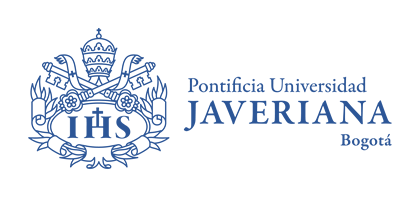

### **Profesor**
* Sergio Mora
### **Integrantes**
* Javier Acero
* Gerson Gaitan
* Juan Sebastian Amaya Velasco
* Diana Marcela González Figueroa

In [1]:
import subprocess
import sys

# Lista de paquetes a verificar/instalar
packages = [
    "numpy", "pandas", "sklearn", "opencv-python", "torch", "torchvision"]

for package in packages:
    try:
        __import__(package)
        print(f"Ok  {package} ya está instalado.")
    except ImportError:
        print(f"Fail  {package} no está instalado. Instalando...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Ok  {package} instalado correctamente.")


Ok  numpy ya está instalado.
Ok  pandas ya está instalado.
Ok  sklearn ya está instalado.
Fail  opencv-python no está instalado. Instalando...
Ok  opencv-python instalado correctamente.
Fail  torch no está instalado. Instalando...
Ok  torch instalado correctamente.
Fail  torchvision no está instalado. Instalando...
Ok  torchvision instalado correctamente.


# Tranfer Learnning to Flower Recognition using PyTorch 🔥
This dataset contains labeled 4242 images of flowers.


### Content
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Data
You can download data from: [Flowers Recognition Dataset](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

Se extrae la data del set de datos de Flowers Recognition Dataset de Kaggle

In [1]:
import numpy as np
import pandas as pd
import os
path="./"
os.listdir(path)

['.config', 'archive.zip', '.ipynb_checkpoints', 'sample_data']

In [2]:
!unzip archive.zip

Archive:  archive.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: fl

Se identifican las 5 categorías de flores identificadas para el ejercicio. Para este caso serán tulip, sunflower, rose, dandelion y daisy

In [3]:
path="./flowers"
os.listdir(path)

['tulip', 'sunflower', 'rose', 'dandelion', 'daisy']

In [4]:
classes=['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

Se identifican un total de 4316 imagenes que serán utilizadas paa el entrenamiento del modelo

In [5]:
label_of_file=[]
img_list=[]

for kind in classes:
    kind_parh=os.path.join(path,kind)

    for img in os.listdir(kind_parh):
        img_list.append(os.path.join(kind_parh,img))
        label_of_file.append(kind)

df=pd.DataFrame({'img':img_list,'label':label_of_file})
df.head(3)
df = df.sample(frac=1).reset_index(drop=True)
df.tail(2)

,img,label
4315,./flowers/dandelion/18243329421_771b4d938e.jpg,dandelion
4316,./flowers/sunflower/3575811488_a31714472a.jpg,sunflower


In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df['encode_label'] = encoder.fit_transform(df['label'])

In [7]:
df.head(10)

,img,label,encode_label
0,./flowers/dandelion/7448453384_fb9caaa9af_n.jpg,dandelion,1
1,./flowers/tulip/13911047024_8966d70560_n.jpg,tulip,4
2,./flowers/tulip/5417115048_3b78d6c875_n.jpg,tulip,4
3,./flowers/sunflower/9448615838_04078d09bf_n.jpg,sunflower,3
4,./flowers/tulip/14073608876_49db8ac97d_n.jpg,tulip,4
5,./flowers/sunflower/20812318934_82f10c45a1_n.jpg,sunflower,3
6,./flowers/tulip/8484905084_6a18c62b13_m.jpg,tulip,4
7,./flowers/sunflower/6606820461_952c450f90_n.jpg,sunflower,3
8,./flowers/sunflower/6495554833_86eb8faa8e_n.jpg,sunflower,3
9,./flowers/tulip/112428919_f0c5ad7d9d_n.jpg,tulip,4


In [8]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

In [9]:
example_img = cv2.imread(df['img'][2])
example_img.shape

(266, 320, 3)

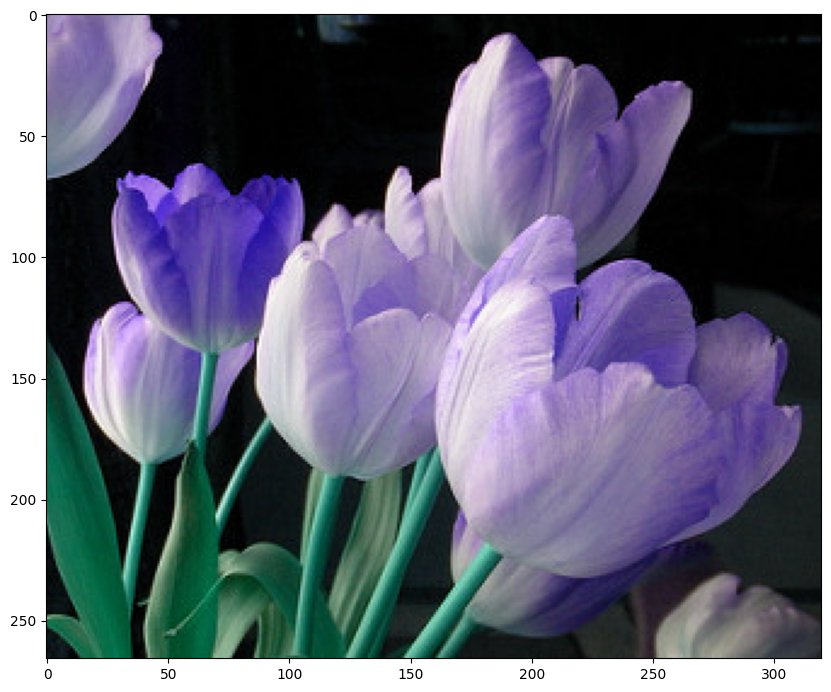

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(example_img)
plt.show()

In [11]:
import numpy as np
x=[]
for img in df['img']:
    try:
        img = cv2.imread(img)
        img = cv2.resize(img, (150, 150))
        img = img / 255.0  # normalize
        x.append(img)      # img

    except:
        print(f"Error loading image: {img}")

Se convieten los arreglos de imagenes en tensores. Lo anterior tiene como objetivo el uso del paquete Pytorch, y poder utilizar en primer lugar este paquete, y un entorno de ejecución mas poderoso como GPU

In [12]:
x_tensors = torch.tensor(x, dtype=torch.float32)
y_tensors = torch.tensor(df['encode_label'].values, dtype=torch.long)

<ipython-input-12-5d33347b49f9>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  x_tensors = torch.tensor(x, dtype=torch.float32)


Despues de la transaformación, se obtiene un tensor de 4317 imagenes, cada imagene de un tamaño de 150 x 150 pixeles (estandarización del tamaño), y 3 canales de color

In [13]:
print(x_tensors.shape)
print(y_tensors.shape)

torch.Size([4317, 150, 150, 3])
torch.Size([4317])


Se separa la data de manera aleatoria para obtener un set de datos de entrenamiento y otro de prueba.En este caso, los set de datos es el tensor y sus respectivas etiquetas

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_tensors, y_tensors, test_size=0.2, random_state=42)

## Modeling

Se crea la función FlowerDataset para encabsular las imagenes con su respectiva etiqueta.

In [15]:
class FlowerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform  # Transformaciones de imágenes (opcional)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)  # Aplicamos transformaciones

        return image, label

Se crean los conjuntos de datos a través de FlowerDataset y ya con los datasets, se crean los dataloaders por paquetes de 32 imagenes cada uno. Lo anterior optimiza el entrenamiento.

In [16]:
train_dataset = FlowerDataset(x_train, y_train)
test_dataset = FlowerDataset(x_test, y_test)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Número de batches en entrenamiento: {len(train_loader)}")
print(f"Número de batches en validación: {len(test_loader)}")

Número de batches en entrenamiento: 108
Número de batches en validación: 27


Se configura un red neuronal preentrenada

In [17]:
# make model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.1MB/s]


Se configua la función de perdida y en optimizador

In [18]:
# train Model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Se crea la función de entrenamiento de la red neuronal. Como tal red neuronal recibe el modelo que utilizará para el entrenamiento, el optmizados, el dataloader y el número de epocas revisa si puede utilizar GPU. Cabe resaltar dentro de la función el reorddenamiento de las dimensiones de verlo necesario.

In [19]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=25):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        size = len(dataloader.dataset)  # Obtiene el número total de ejemplos

        for batch, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Asegurar que las imágenes estén en formato correcto
            if inputs.dim() == 4 and inputs.shape[-1] == 3:
                inputs = inputs.permute(0, 3, 1, 2)  # Convertir de [B, H, W, C] → [B, C, H, W]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        print(f"Epoch {epoch+1}/{num_epochs} Loss: {running_loss / size:.6f}")

    print("Entrenamiento finalizado ✅")

Evaluación de los resultados generados por el modelo de entrenamiento.

In [20]:
def test(dataloader, model, loss_fn):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Modo evaluación

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Asegurar que las imágenes tengan la forma correcta
            if X.dim() == 4 and X.shape[-1] == 3:
                X = X.permute(0, 3, 1, 2)  # [B, H, W, C] → [B, C, H, W]

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches  # Promediar la pérdida
    correct /= size  # Calcular precisión

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:.6f} \n")

    return test_loss, correct * 100  # Retorna la pérdida y la precisión en porcentaje

In [21]:
torch.cuda.is_available()

True

Se inicia el proceso de entreanmeinto y evaluación del modelo. Para este caso se llama el modelo preentrenado ResNet-18 que clasifica las imagenes en las 5 categorias identificadas de flores, utiliza la función de perdida CrossEntropyLoss y el optimizador utiliza un SGD con un learning rate de 0.001 y un momentum de 0.9. EL modelo recive el dataloader con paquetes de 32 imagenes cada uno y se utiliza un total de 20 epocas para entrenar el modelo.

In [22]:
# training
train_model(model, criterion, optimizer, train_loader, num_epochs=5)
test(test_loader, model, criterion)

Epoch 1/5 Loss: 0.784482
Epoch 2/5 Loss: 0.298819
Epoch 3/5 Loss: 0.174758
Epoch 4/5 Loss: 0.101727
Epoch 5/5 Loss: 0.063615
Entrenamiento finalizado ✅
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.371356 



(0.371356381310357, 88.6574074074074)

Se obseva un potencial sobreajuste debido a las gandes diferencias que hay en los resultados de log loss, aun así el resultado del modelo presenta un accuracy de 88,65% que es aceptable para el ejercicio